# Choosing Boxes Problem

as shown in the [problem formulation guide](https://www.dwavesys.com/media/bu0lh5ee/problem-formulation-guide-2022-01-10.pdf).


- https://github.com/dwave-training/choosing-boxes

## Problem

Pick 2 Boxes and minimize the summed weight.

| Box   | Weight |
| ----- | ------ |
| $x_1$ | 15     |
| $x_2$ | 20     |
| $x_3$ | 25     |

QUBO:  
Objective: $min(15x_1 + 20x_2 + 25x_3)$  
Constraint: $x_1 + x_2 + x_3 = 2$

## Mathematical formulation

For $\gamma = 1$ (Lagrange Multiplier)

$$
\begin{align}
    & min
    (
        (15x_1 + 20x_2 + 25x_3)

        +\gamma
        {
            \underbrace{
                (x_1+x_2+x_3-2)^2
            }_{
                \underbrace{
                    x_1^2 
                    - 4 x_1 
                    + x_2^2 
                    - 4 x_2 
                    + x_3^2 
                    - 4 x_3 

                    + 2 x_1 x_2
                    + 2 x_1 x_3 
                    + 2 x_2 x_3 

                    + 4
                }_{
                    - 3x_1 - 3x_2 - 3x_3
                    + 2x_1x_2 + 2x_1x_3 + 2x_2x_3
                    + 4
                    \quad
                    (x_i^2 = x_i \ \text{with} \ x_i \in \{0,1\})
                }
            }
        }
    ) \\

    & = min
    \left(
        15x_1
        - 3x_1
        + 20x_2
        - 3x_2
        + 25x_3
        - 3x_3
        + 2x_1x_2
        + 2x_1x_3
        + 2x_2x_3
        + 4
    \right) \\ 

    & = min
    \left(
        \underbrace{
            12x_1
            + 17x_2
            + 22x_3
        }_{\text{linear terms}}
        +
        \underbrace{
            2x_1x_2
            + 2x_1x_3
            + 2x_2x_3
        }_{\text{quadratic terms}}
        + 4
    \right) \\

    & \Rightarrow
    Q = 
    \left(
        \begin{matrix}
            12  & 2  & 2 \\
                & 17 & 2 \\
                &    & 22 \\
        \end{matrix}
    \right)
\end{align}
$$

## BQM & CQM

Use Formula (1) in BQM or the objective & constraint functions in CQM to solve the problem on a QA.

[D-Wave Docs: Quadratic Models](https://docs.dwavesys.com/docs/latest/c_gs_workflow.html#quadratic-models)  
[D-Wave Docs: Problem Parameters](https://docs.dwavesys.com/docs/latest/c_solver_problems.html#bqm)

In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd

from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridCQMSampler
import dwave.inspector
import dimod

### BQM

In [1]:
γ = 35
x1 = dimod.Binary("x1")
x2 = dimod.Binary("x2")
x3 = dimod.Binary("x3")

bqm = 15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2
print(bqm)

sampler_bqm = EmbeddingComposite(DWaveSampler())
sampleset_bqm = sampler_bqm.sample(bqm, num_reads = 10)

print(sampleset_bqm)

BinaryQuadraticModel({'x1': -90.0, 'x2': -85.0, 'x3': -80.0}, {('x2', 'x1'): 70.0, ('x3', 'x1'): 70.0, ('x3', 'x2'): 70.0}, 140.0, 'BINARY')

  x1 x2 x3 energy num_oc. chain_.
0  1  1  0   35.0       3     0.0
1  1  0  1   40.0       6     0.0
2  0  0  1   60.0       1     0.0
['BINARY', 3 rows, 10 samples, 3 variables]


### CQM

In [2]:
symbols = [dimod.Binary(f'x{i}') for i in range(1, 4)]
x1, x2, x3 = symbols


cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(15 * x1 + 20 * x2 + 25 * x3)
cqm.add_constraint(x1 + x2 + x3 == 2, label = "pick exactly 2 boxes")

# print(cqm)
# pprint(vars(cqm))

sampler_cqm = LeapHybridCQMSampler()
# print(sampler_cqm.parameters)
sampleset_cqm = sampler_cqm.sample_cqm(cqm)
# sampleset_cqm = dimod.ExactCQMSolver().sample_cqm(cqm)

print(sampleset_cqm)

    x1  x2  x3 energy num_oc. is_sat. is_fea.
3  1.0 1.0 0.0   35.0       1 arra...    True
4  1.0 1.0 0.0   35.0       1 arra...    True
5  1.0 1.0 0.0   35.0       1 arra...    True
8  1.0 1.0 0.0   35.0       1 arra...    True
9  1.0 1.0 0.0   35.0       1 arra...    True
10 1.0 1.0 0.0   35.0       1 arra...    True
11 1.0 1.0 0.0   35.0       1 arra...    True
12 1.0 1.0 0.0   35.0       1 arra...    True
13 1.0 1.0 0.0   35.0       1 arra...    True
14 1.0 1.0 0.0   35.0       1 arra...    True
15 1.0 1.0 0.0   35.0       1 arra...    True
16 1.0 1.0 0.0   35.0       1 arra...    True
17 1.0 1.0 0.0   35.0       1 arra...    True
18 1.0 1.0 0.0   35.0       1 arra...    True
19 1.0 1.0 0.0   35.0       1 arra...    True
20 1.0 1.0 0.0   35.0       1 arra...    True
21 1.0 1.0 0.0   35.0       1 arra...    True
22 1.0 1.0 0.0   35.0       1 arra...    True
23 1.0 1.0 0.0   35.0       1 arra...    True
24 1.0 1.0 0.0   35.0       1 arra...    True
25 1.0 1.0 0.0   35.0       1 arra

### Lagrange Multiplier (γ) Comparison

In [6]:
samplesets = {}
for γ in [10, 20, 30, 35, 40, 50, 60, 70, 80]:
    x1, x2, x3 = [dimod.Binary(f'x{i}') for i in range(1, 4)]
    # Q = make_Q_dict(make_qubo(γ = γ))

    bqm = 15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2
    display(bqm)

    sampler = EmbeddingComposite(DWaveSampler())
    sampleset = sampler.sample(bqm, num_reads = 10)
    # sampleset = sampler.sample_qubo(Q, num_reads = 100)

    print(f'>>>   γ = {γ}   <<<')
    print(sampleset)
    print()
    samplesets[γ] = sampleset

>>>   γ = 10   <<<
   0  1  2 energy num_oc. chain_.
0  1  0  0  -15.0      89     0.0
1  0  1  0  -10.0      11     0.0
['BINARY', 2 rows, 100 samples, 3 variables]

>>>   γ = 20   <<<
   0  1  2 energy num_oc. chain_.
0  1  0  0  -45.0      41     0.0
1  1  1  0  -45.0      52     0.0
2  0  1  0  -40.0       3     0.0
3  1  0  1  -40.0       3     0.0
4  0  1  1  -35.0       1     0.0
['BINARY', 5 rows, 100 samples, 3 variables]

>>>   γ = 30   <<<
   0  1  2 energy num_oc. chain_.
0  1  1  0  -85.0      74     0.0
1  1  0  1  -80.0      20     0.0
2  0  1  1  -75.0       3     0.0
3  1  0  0  -75.0       2     0.0
4  0  1  0  -70.0       1     0.0
['BINARY', 5 rows, 100 samples, 3 variables]

>>>   γ = 35   <<<
   0  1  2 energy num_oc. chain_.
0  1  1  0 -105.0      76     0.0
1  1  0  1 -100.0      16     0.0
2  0  1  1  -95.0       5     0.0
3  1  0  0  -90.0       1     0.0
4  0  1  0  -85.0       1     0.0
5  0  0  1  -80.0       1     0.0
['BINARY', 6 rows, 100 samples, 3 vari

<AxesSubplot:xlabel='None,#'>

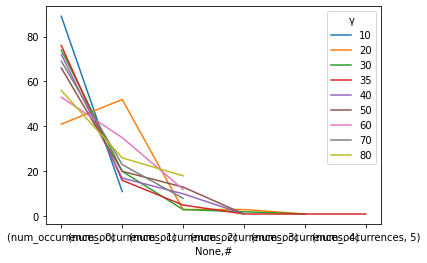

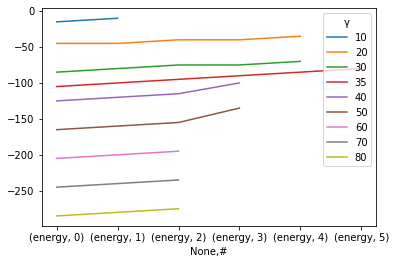

In [ ]:
df = pd.concat({γ: s.to_pandas_dataframe() for γ, s in samplesets.items()}).rename_axis(index = ["γ", "#"])

# df["result"] = df[0].astype(str) + df[1].astype(str) + df[2].astype(str)
# df["result"] = df["result"].apply(lambda x: int(f'0b{x}', 2))
df["result"] = df[0] * 15 + df[1] * 20 + df[2] * 25
df["#picked"] = df[0] + df[1] + df[2]
# df.set_index("result")

# display(df.style.bar(subset = ["energy", "num_occurrences"]).background_gradient(subset = "result", cmap = "Blues_r").background_gradient(subset = "#picked"))
display(
    df.style.bar(
        subset = ["energy", "num_occurrences"],
    ).set_properties(
        **{'background-color': '#ffffb33b'},
        subset = pd.IndexSlice[pd.IndexSlice[df.index.unique(level = 0)[::2], :], :]
    ).background_gradient(
        subset = "result",
        cmap = "Blues_r"
    ).background_gradient(
        subset = "#picked",
        cmap = "Blues_r"
    )
)

df = df.T.stack()

# df = df.reset_index(level = 1, drop = True)
# df = df.reset_index()

# df[["energy", "num_occurrences"]].plot()
# df.drop(columns = [0, 1, 2, "#"]).plot()
# df.drop(columns = [0, 1, 2, "#"]).groupby(by = "γ").plot()
# df.drop(index = [0, 1, 2, ]).plot()
# df.loc[["energy", "num_occurrences"]].plot()
df.loc[["num_occurrences"]].plot()
df.loc[["energy", ]].plot()
# df.loc[["chain_break_fraction", ]].plot()
# df.plot()

## QUBO Matrix

In [ ]:
import itertools
from copy import deepcopy
from collections import defaultdict
from pprint import pprint

import numpy as np
# !pip install sympy
import sympy

from dwave.system import DWaveSampler, EmbeddingComposite
import dwave.inspector
import dimod

In [ ]:
def make_Q(qubo: sympy.Expr):
    """
    takes a QUBO sympy expression and returns the QUBO matrix.
    """
    qubo = sympy.cancel(qubo)  # simplified
    qubo = qubo.subs({x ** 2: x for x in symbols})  # x_i^2 = x_i   with x_i ∈ {0,1}
    qubo = qubo.as_poly()
    qubo_dict = qubo.as_dict()
    qubo_dict = sorted(tuple(qubo_dict.items()), reverse = True)
    num_vars = len(qubo.free_symbols)
    Q = np.zeros((num_vars, num_vars), dtype = int)
    # print(Q)

    def group_rows(qubo: dict):
        rows = {}
        for i in range(num_vars):
            row = [(coord, coef) for ix, (coord, coef) in enumerate(qubo) if coord[i] == 1]
            rows[i] = row
            for elem in row:
                qubo.remove(elem)
        rows = {k: {"linear": [e for e in v if sum(e[0]) == 1], "quadratic": [e for e in v if sum(e[0]) > 1]} for k, v in rows.items()}
        return rows
    rows = group_rows(qubo_dict)
    # print(rows)

    def fill_Q(rows, Q):
        for ir, row in rows.items():
            for (ic, col) in row["quadratic"]:
                Q[(ir, ic.index(1, ir + 1))] = col
            for (ic, col) in row["linear"]:
                Q[(ir, ir)] = col
        return Q
    Q = fill_Q(rows, Q)

    return Q


# print("QUBO matrix")
# make_Q(qubo)

In [ ]:
def make_qubo(γ = 35, verbose = False):
    """
    make QUBO for the choosing boxes problem:
    min(15a + 20b + 25c + γ * (a + b + c - 2)^2)

    Args:
        γ: int or list of ints ( in the latter case the outputs for all will be printed and the last one returned)
    """
    γs = γ if isinstance(γ, list) else [γ]
    γ = γs[-1]

    # x1 = sympy.Symbol("x1")
    symbols = sympy.symbols("x1 x2 x3")
    x1, x2, x3 = symbols

    # display( sympy.simplify((x1 + x2 + x3 - 2)**2) )
    # display( sympy.trigsimp((x1 + x2 + x3 - 2)**2) )
    # display( sympy.cancel((x1 + x2 + x3 - 2)**2) )

    if verbose:
        print("QUBO:")
        display(15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2)

    for γ in γs:
        qubo = sympy.cancel(15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2)  # simplified
        qubo = qubo.subs({x ** 2: x for x in symbols})  # x_i^2 = x_i   with x_i ∈ {0,1}

        Q = make_Q(qubo)
        if verbose:
            print(f'Simplified QUBO with γ = {γ}')
            display(qubo)

            print("QUBO matrix")
            print(Q)
    return Q


Q = make_qubo(γ = [1, 4, 30, 40], verbose = True)
# for i in [1,4,40]: make_qubo(γ = i, verbose = True)

QUBO:


15*x1 + 20*x2 + 25*x3 + 40*(x1 + x2 + x3 - 2)**2

Simplified QUBO with γ = 1


2*x1*x2 + 2*x1*x3 + 12*x1 + 2*x2*x3 + 17*x2 + 22*x3 + 4

QUBO matrix
[[12  2  2]
 [ 0 17  2]
 [ 0  0 22]]
Simplified QUBO with γ = 4


8*x1*x2 + 8*x1*x3 + 3*x1 + 8*x2*x3 + 8*x2 + 13*x3 + 16

QUBO matrix
[[ 3  8  8]
 [ 0  8  8]
 [ 0  0 13]]
Simplified QUBO with γ = 30


60*x1*x2 + 60*x1*x3 - 75*x1 + 60*x2*x3 - 70*x2 - 65*x3 + 120

QUBO matrix
[[-75  60  60]
 [  0 -70  60]
 [  0   0 -65]]
Simplified QUBO with γ = 40


80*x1*x2 + 80*x1*x3 - 105*x1 + 80*x2*x3 - 100*x2 - 95*x3 + 160

QUBO matrix
[[-105   80   80]
 [   0 -100   80]
 [   0    0  -95]]


In [ ]:
def make_Q_dict(Q, verbose = False):
    """
    Prepare the Q matrix for DWaveSampler()
    """
    Q = Q.astype(float)  # for nan masking
    if verbose:
        pprint(Q)

    # np.mgrid[:Q.shape[0], :Q.shape[1]]
    # Q[np.mask_indices(Q.shape[0], np.triu)]

    # tril_indices = np.tril_indices(Q.shape[0], k = -1)
    triu_indices = np.triu_indices(Q.shape[0])
    # triu_indices = np.dstack(triu_indices)[0]

    mask = np.ones_like(Q).astype(bool)
    mask[triu_indices] = False

    assert np.isnan(Q[mask]).all() or (Q[mask] == 0).all(), "Lower triangle should not contain any values"

    # set lower triangle to np.nan
    Q[mask] = np.nan
    # Q[tril_indices] = np.nan

    # Q = dict(zip(list(zip(*triu_indices)), Q[triu_indices]))
    Q = {k: v for (k, v) in np.ndenumerate(Q) if not np.isnan(v)}

    if verbose:
        pprint(Q)
    return Q


Q = make_Q_dict(make_qubo(γ = 40, verbose = False), verbose = True)
# for i in [1,4,40]: make_Q_dict(make_qubo(γ = i, verbose = False), verbose = True)

array([[-105.,   80.,   80.],
       [   0., -100.,   80.],
       [   0.,    0.,  -95.]])
{(0, 0): -105.0,
 (0, 1): 80.0,
 (0, 2): 80.0,
 (1, 1): -100.0,
 (1, 2): 80.0,
 (2, 2): -95.0}


### Run Problem on D-Wave QA

In [ ]:
Q = make_Q_dict(make_qubo(γ = 35))

sampler = EmbeddingComposite(DWaveSampler())

# Create a bqm object...
bqm = dimod.BQM.from_qubo(Q)
sampleset = sampler.sample(bqm, num_reads = 10)

# ...or use sample_qubo() directly.
# sampleset = sampler.sample_qubo(Q, num_reads = 10)

In [7]:
print(sampleset, end = "\n\n")
pprint(vars(sampleset)); print()
sampleset

   0  1  2 energy num_oc. chain_.
0  1  1  0 -105.0       6     0.0
1  1  0  1 -100.0       2     0.0
2  0  1  1  -95.0       1     0.0
3  1  0  0  -90.0       1     0.0
['BINARY', 4 rows, 10 samples, 3 variables]

{'_info': {'problem_id': 'ae49c94b-c722-43a9-8bda-cc538266031e',
           'timing': {'post_processing_overhead_time': 764.0,
                      'qpu_access_overhead_time': 20109.2,
                      'qpu_access_time': 9285.8,
                      'qpu_anneal_time_per_sample': 20.0,
                      'qpu_delay_time_per_sample': 20.54,
                      'qpu_programming_time': 8448.6,
                      'qpu_readout_time_per_sample': 43.18,
                      'qpu_sampling_time': 837.2,
                      'total_post_processing_time': 764.0}},
 '_record': rec.array([([1, 1, 0], -105., 6, 0.), ([1, 0, 1], -100., 2, 0.),
           ([0, 1, 1],  -95., 1, 0.), ([1, 0, 0],  -90., 1, 0.)],
          dtype=[('sample', 'i1', (3,)), ('energy', '<f8'), ('num_

## Trash

In [ ]:
# # help(np.ma.masked_array)
# mask = np.zeros_like(Q).astype(bool)
# # mask = np.empty_like(Q)
# # mask = Q.copy()
# # print(mask)
# # mask = np.where(lambda x: np.isnan, Q, True)
# # mask[np.isnan(mask)] = False
# mask[triu_indices] = True
# # mask = mask.astype(bool)
# print(mask)
# Q[mask]

Q2 = np.ma.array(Q, mask = mask)
# Q2 = np.ma.masked_array(Q, mask = mask)
print(Q2)

print(dict(np.ndenumerate(Q2)).values())

Q2

print()
print(np.ma.clump_masked(Q2))
print(np.ma.clump_unmasked(Q2))
print(np.ma.flatnotmasked_contiguous(Q2))
print(np.ma.flatnotmasked_edges(Q2))
print(np.ma.notmasked_contiguous(Q2))
print(np.ma.notmasked_edges(Q2))

In [ ]:
np.triu(Q)
Q[np.mask_indices(Q.shape[0], np.tril)]

# np.ma.array(Q, mask = np.triu_indices(Q.shape[0]))
# np.ma.array(Q, mask = np.vstack(np.triu_indices(Q.shape[0])).T)
# np.ma.array(Q, mask = np.dstack(triu_indices)[0])
# np.ma.array(Q, mask = list(zip(*triu_indices)))

# np.vstack(np.triu_indices(Q.shape[0])).T
# np.dstack(triu_indices)[0]
# list(zip(*triu_indices))
print(np.mask_indices(Q.shape[0], np.triu))
print(np.triu_indices(Q.shape[0]))

In [ ]:
# # sympy.linear_eq_to_matrix(qubo, *symbols)
# print([qubo.coeff(symbol ** 2) for symbol in symbols])
# print([qubo.coeff(symbol) for symbol in symbols])

# # print(sympy.decompose(qubo))

# print("deg ls:  ", sympy.degree_list(qubo))
# print("deg:     ", sympy.degree(qubo, gen = x1))
# print("LC:      ", sympy.LC(qubo))
# print("LM:      ", sympy.LM(qubo))

# print("Poly()")
# qubo_poly = qubo.as_poly()
# print("as_poly: ", qubo_poly)
# print("EC:      ", qubo_poly.EC())
# print("EM:      ", qubo_poly.EM())
# print("as_list: ", qubo_poly.as_list())

# qubo_dict = qubo_poly.as_dict()
# print("as_dict: ", qubo_dict)
# pprint(qubo_dict)

In [123]:
from pprint import pprint
import pandas as pd


t = """
 	 	0	1	2	chain_break_fraction	energy	num_occurrences	result	#picked
γ	#	 	 	 	 	 	 	 	 
10	0	1	0	0	0.000000	-15.000000	89	15	1
	1	0	1	0	0.000000	-10.000000	11	20	1
20	0	1	0	0	0.000000	-45.000000	41	15	1
	1	1	1	0	0.000000	-45.000000	52	35	2
	2	0	1	0	0.000000	-40.000000	3	20	1
	3	1	0	1	0.000000	-40.000000	3	40	2
	4	0	1	1	0.000000	-35.000000	1	45	2
30	0	1	1	0	0.000000	-85.000000	74	35	2
	1	1	0	1	0.000000	-80.000000	20	40	2
	2	0	1	1	0.000000	-75.000000	3	45	2
	3	1	0	0	0.000000	-75.000000	2	15	1
	4	0	1	0	0.000000	-70.000000	1	20	1
35	0	1	1	0	0.000000	-105.000000	76	35	2
	1	1	0	1	0.000000	-100.000000	16	40	2
	2	0	1	1	0.000000	-95.000000	5	45	2
	3	1	0	0	0.000000	-90.000000	1	15	1
	4	0	1	0	0.000000	-85.000000	1	20	1
	5	0	0	1	0.000000	-80.000000	1	25	1
40	0	1	1	0	0.000000	-125.000000	72	35	2
	1	1	0	1	0.000000	-120.000000	17	40	2
	2	0	1	1	0.000000	-115.000000	10	45	2
	3	0	1	0	0.000000	-100.000000	1	20	1
50	0	1	1	0	0.000000	-165.000000	66	35	2
	1	1	0	1	0.000000	-160.000000	20	40	2
	2	0	1	1	0.000000	-155.000000	13	45	2
	3	1	0	0	0.000000	-135.000000	1	15	1
60	0	1	1	0	0.000000	-205.000000	53	35	2
	1	1	0	1	0.000000	-200.000000	35	40	2
	2	0	1	1	0.000000	-195.000000	12	45	2
70	0	1	1	0	0.000000	-245.000000	69	35	2
	1	1	0	1	0.000000	-240.000000	23	40	2
	2	0	1	1	0.000000	-235.000000	8	45	2
80	0	1	1	0	0.000000	-285.000000	56	35	2
	1	1	0	1	0.000000	-280.000000	26	40	2
	2	0	1	1	0.000000	-275.000000	18	45	2"""

t2 = {}
k = None
for x in [x.split("\t") for x in t.splitlines()[3:]]:
	if x[0]:
		k = x[0]
	# 	t2[k] = {}
	# t2[k][x[1]] = x[2:]
	t2[(int(k), int(x[1]))] = list(map(float, x[2:]))
	# t2[(k, x[1])] = x[2:]
pprint(t2)

df = pd.DataFrame.from_dict(t2, orient = "index", columns = ["0", "1", "2", "chain_break_fraction", "energy", "num_occurrences", "result", "#picked"])
df = df.convert_dtypes()
df.index = pd.MultiIndex.from_tuples(df.index, names = ["γ", "#"])
df

{(10, 0): [1.0, 0.0, 0.0, 0.0, -15.0, 89.0, 15.0, 1.0],
 (10, 1): [0.0, 1.0, 0.0, 0.0, -10.0, 11.0, 20.0, 1.0],
 (20, 0): [1.0, 0.0, 0.0, 0.0, -45.0, 41.0, 15.0, 1.0],
 (20, 1): [1.0, 1.0, 0.0, 0.0, -45.0, 52.0, 35.0, 2.0],
 (20, 2): [0.0, 1.0, 0.0, 0.0, -40.0, 3.0, 20.0, 1.0],
 (20, 3): [1.0, 0.0, 1.0, 0.0, -40.0, 3.0, 40.0, 2.0],
 (20, 4): [0.0, 1.0, 1.0, 0.0, -35.0, 1.0, 45.0, 2.0],
 (30, 0): [1.0, 1.0, 0.0, 0.0, -85.0, 74.0, 35.0, 2.0],
 (30, 1): [1.0, 0.0, 1.0, 0.0, -80.0, 20.0, 40.0, 2.0],
 (30, 2): [0.0, 1.0, 1.0, 0.0, -75.0, 3.0, 45.0, 2.0],
 (30, 3): [1.0, 0.0, 0.0, 0.0, -75.0, 2.0, 15.0, 1.0],
 (30, 4): [0.0, 1.0, 0.0, 0.0, -70.0, 1.0, 20.0, 1.0],
 (35, 0): [1.0, 1.0, 0.0, 0.0, -105.0, 76.0, 35.0, 2.0],
 (35, 1): [1.0, 0.0, 1.0, 0.0, -100.0, 16.0, 40.0, 2.0],
 (35, 2): [0.0, 1.0, 1.0, 0.0, -95.0, 5.0, 45.0, 2.0],
 (35, 3): [1.0, 0.0, 0.0, 0.0, -90.0, 1.0, 15.0, 1.0],
 (35, 4): [0.0, 1.0, 0.0, 0.0, -85.0, 1.0, 20.0, 1.0],
 (35, 5): [0.0, 0.0, 1.0, 0.0, -80.0, 1.0, 25.0, 1.0],


0  1  2  chain_break_fraction  energy  num_occurrences  result  #picked
γ  #                                                                         
10 0  1  0  0                     0     -15               89      15        1
   1  0  1  0                     0     -10               11      20        1
20 0  1  0  0                     0     -45               41      15        1
   1  1  1  0                     0     -45               52      35        2
   2  0  1  0                     0     -40                3      20        1
   3  1  0  1                     0     -40                3      40        2
   4  0  1  1                     0     -35                1      45        2
30 0  1  1  0                     0     -85               74      35        2
   1  1  0  1                     0     -80               20      40        2
   2  0  1  1                     0     -75                3      45        2
   3  1  0  0                     0     -75                2      15        1
   4  0  1  0                     0     -70                1      20        1
35 0  1  1  0                     0    -105               76      35        2
   1  1  0  1                     0    -100               16      40        2
   2  0  1  1                     0     -95                5      45        2
   3  1  0  0                     0     -90                1      15        1
   4  0  1  0                     0     -85                1      20        1
   5  0  0  1                     0     -80                1      25        1
40 0  1  1  0                     0    -125               72      35        2
   1  1  0  1                     0    -120               17      40        2
   2  0  1  1                     0    -115               10      45        2
   3  0  1  0                     0    -100                1      20        1
50 0  1  1  0                     0    -165               66      35        2
   1  1  0  1                     0    -160               20      40        2
   2  0  1  1                     0    -155               13      45        2
   3  1  0  0                     0    -135                1      15        1
60 0  1  1  0                     0    -205               53      35        2
   1  1  0  1                     0    -200               35      40        2
   2  0  1  1                     0    -195               12      45        2
70 0  1  1  0                     0    -245               69      35        2
   1  1  0  1                     0    -240               23      40        2
   2  0  1  1                     0    -235                8      45        2
80 0  1  1  0                     0    -285               56      35        2
   1  1  0  1                     0    -280               26      40        2
   2  0  1  1                     0    -275               18      45        2